# TestIntraCellularLungCancerBiomarkers
Andrew E. Davidson  
aedavids@ucsc.edu  
1/15/24  

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

Our goal is to see if the lung cancer biomarkers we found using our 1 vs. All deconvolution pipeline will work on extracelluar RNA plasma samples. The first step is to see how well these bio markers work on intracellular samples. Will using our GTEx_TCGA training, validation and test data sets

**Traing Set results**  
- 341 healthy lung sample
- 610 lung cancer. (LUAD, LUSC)
- sensitivity = 0.994, specificity = 1.0
- bio markers
```
LUAD genes:
['AC011944.1', 'ATP13A4-AS1', 'AC090004.1', 'GXYLT1P3', 'AC126323.6', 'AC111149.2', 'AL365181.4', '(TCCAC)n', 'BPIFA2', 'IGHJ5']

LUSC genes:
['FMO6P', 'AC121493.1', 'AP001120.2', 'LINC01249', 'AP000344.1', '(TCTATG)n', 'AC092140.2', 'AP001360.1', 'ENPP7P11', 'AC018521.2']

 healthy control Lung genes:
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']
```

**Holdout Set Results**  
TODO AEDWIP we do not have deseq scalling factors for hold out sets. we ran our 1vsAll docker in terra on
the training data set only. we have the code to calculate the scaling factors. run on all 26K samples then split out validate and test.

double check that the training scaling factors did not change


In [1]:
import ipynbname
import joblib
import os
import pandas as pd
import scikitplot as skplt
import sys

notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

LOCAL_CACHE_DIR=f"/scratch/aedavids/tmp/"

outDir:
/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from analysis.signatureMatrixMetrics import checkForSparcity
from analysis.utilities import loadDictionary
from confusion_matrix.cf_matrix import make_confusion_matrix
from intraExtraRNA.deseqUtilities import normalize
from intraExtraRNA.utilities import load, selectSamples

## Load data

In [4]:
# select lung cancer signature, (biomarker), genes
deconvolutionRoot = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category"
pipelineStageName = "best10CuratedDegree1_ce467ff"
upsetPlotDir = f'{deconvolutionRoot}/{pipelineStageName}/training/best10CuratedDegree1.sh.out/upsetPlot.out'
# the deconvolution gene signature matrix gene name are the values in the intersection dictionary
intersectionDictPath = f'{upsetPlotDir}/best10_from_best500FindAllDegree1_wl500.intersection.dict'
intersectionDictPath = load(intersectionDictPath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)

#print(intersectionDictPath)
intersectionDict = loadDictionary(intersectionDictPath)

LUADGenes = intersectionDict[ ('LUAD',) ]
print(f'LUAD genes:\n{LUADGenes}')

LUSCGenes = intersectionDict[ ('LUSC',) ]
print(f'\nLUSC genes:\n{LUSCGenes}')

# Lung is our healthy control
controlGenes = intersectionDict[ ('Lung',) ]
print(f'\n healthy control Lung genes:\n{controlGenes}')

lungGenes = LUADGenes + LUSCGenes + controlGenes

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/upsetPlot.out/best10_from_best500FindAllDegree1_wl500.intersection.dict

LUAD genes:
['AC011944.1', 'ATP13A4-AS1', 'AC090004.1', 'GXYLT1P3', 'AC126323.6', 'AC111149.2', 'AL365181.4', '(TCCAC)n', 'BPIFA2', 'IGHJ5']

LUSC genes:
['FMO6P', 'AC121493.1', 'AP001120.2', 'LINC01249', 'AP000344.1', '(TCTATG)n', 'AC092140.2', 'AP001360.1', 'ENPP7P11', 'AC018521.2']

 healthy control Lung genes:
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']


In [5]:
%%time
# load gene count data
rootDir = "/private/groups/kimlab/GTEx_TCGA"
sampleDataRoot = rootDir + "/groupbyGeneTrainingSets"
trainGroupByGeneCountFilePath = sampleDataRoot + "/GTEx_TCGA_TrainGroupby.csv"    
groupByGeneCountFilePath = load(trainGroupByGeneCountFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
groupedByGeneDF = pd.read_csv(groupByGeneCountFilePath, sep=",", index_col="geneId")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainGroupby.csv

localTargetPath:/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainGroupby.csv does not exits
copy /private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainGroupby.csv to local cache
CPU times: user 6min 57s, sys: 34.1 s, total: 7min 32s
Wall time: 7min 36s


In [6]:
print(f'groupedByGeneDF.shape : {groupedByGeneDF.shape}')
groupedByGeneDF.iloc[0:3, 0:3]

groupedByGeneDF.shape : (74777, 15801)


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0726-SM-5GIEN
geneId,,,
(A)n,9,1,3
(AAA)n,0,0,0
(AAAAAAC)n,0,0,0


In [7]:
%%time
# load meta data
trainingColDataFilePath = sampleDataRoot + "/GTEx_TCGA_TrainColData.csv"
colDataFilePath = load(trainingColDataFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
colDataDF = pd.read_csv(colDataFilePath, sep=",")
print(f'colDataDF.shape : {colDataDF.shape}')
colDataDF.iloc[0:3, :]

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainColData.csv

localTargetPath:/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainColData.csv does not exits
copy /private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainColData.csv to local cache
colDataDF.shape : (15801, 6)
CPU times: user 35 ms, sys: 19.2 ms, total: 54.2 ms
Wall time: 54.7 ms


,sample_id,participant_id,category,gender,age,dataSet
0,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F,Adipose_Subcutaneous,Female,66.0,GTEx
1,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F,Artery_Tibial,Female,66.0,GTEx
2,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F,Heart_Atrial_Appendage,Female,66.0,GTEx


In [8]:
%%time
# load scaling factors
oneVsAllDataDir = rootDir + "/1vsAll"    
estimatedScalingFactorsFilePath = oneVsAllDataDir + "/estimatedSizeFactors.csv"
scalingFactorsPath = load(estimatedScalingFactorsFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
scalingFactorDF = pd.read_csv(scalingFactorsPath, sep=",")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/estimatedSizeFactors.csv

localTargetPath:/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/estimatedSizeFactors.csv does not exits
copy /private/groups/kimlab/GTEx_TCGA/1vsAll/estimatedSizeFactors.csv to local cache
CPU times: user 4.5 ms, sys: 11.7 ms, total: 16.2 ms
Wall time: 16.6 ms


## Prepare Data

In [9]:
normalizedDF = normalize(groupedByGeneDF, scalingFactorDF)
print(normalizedDF.shape)

(15801, 74777)


In [10]:
normLungDF = selectSamples(colDataDF, normalizedDF, ['LUAD', 'LUSC', 'Lung'])
print(f'normLungDF.shape : {normLungDF.shape}')
normLungDF.iloc[0:3, 0:3]

normLungDF.shape : (957, 74777)


geneId,(A)n,(AAA)n,(AAAAAAC)n
GTEX-111CU-0326-SM-5GZXO,1.996123,0.0,0.0
GTEX-111VG-0726-SM-5GIDC,12.348089,0.0,0.0
GTEX-1122O-0126-SM-5GICA,7.747472,0.0,0.0


In [11]:
normLungDF = normLungDF[ lungGenes ]
print(f'normLungDF.shape {normLungDF.shape}')
normLungDF.iloc[0:3, 0:3]

normLungDF.shape (957, 30)


geneId,AC011944.1,ATP13A4-AS1,AC090004.1
GTEX-111CU-0326-SM-5GZXO,22.955418,677.683873,3.992247
GTEX-111VG-0726-SM-5GIDC,2.058015,11.319081,2.058015
GTEX-1122O-0126-SM-5GICA,15.494945,4.842170,0.000000


In [12]:
# santity check
selectRows = colDataDF.loc[:, "category"].isin(['LUAD', 'LUSC', 'Lung'])
lungColDataDF = colDataDF.loc[selectRows, :]
display( lungColDataDF.groupby(by="category").count() )
assert 957 == 309 + 301 + 347 , "ERROR number of samples does not agree"

,sample_id,participant_id,gender,age,dataSet
category,,,,,
LUAD,309,309,309,309,309
LUSC,301,301,301,301,301
Lung,347,347,347,347,347


In [13]:
# create labels

# lump LUAD and LUSC
selectLUAD_LUSC_rows = lungColDataDF.loc[:, 'category'].isin( ['LUAD', 'LUSC'])
lungColDataDF.loc[selectLUAD_LUSC_rows, 'category'] = "LungCancer"

# selectSamples = colDataDF.loc[:, "sample_id"].isin(lungDF.index)
# conditionList = colDataDF.loc[selectSamples, 'category'].tolist()
conditionList = lungColDataDF.loc[:, 'category'].tolist()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
Lung,347
LungCancer,610


,cat,oneHot
0,Lung,0
1,Lung,0
2,Lung,0
3,Lung,0
4,Lung,0


,cat,oneHot
952,LungCancer,1
953,LungCancer,1
954,LungCancer,1
955,LungCancer,1
956,LungCancer,1


In [14]:
# XNP = groupedByGeneDF.values #.transpose()
XNP = normLungDF.values
print(XNP.shape)

(957, 30)


# Check for sparcity

In [16]:
noZeroDF, rowSumDF, rowSumSummaryDF, geneCountSeries, sparcity = checkForSparcity(normLungDF, lungColDataDF)
print(f'sparcity % values ! = 0 : {sparcity * 100}%')

print(f'\nrowSumSummaryDF\n')
display( rowSumSummaryDF )

print(f'\ngeneCountSeries: number of non zero values for each gene\n')
display( geneCountSeries )

print(f'\nrowSumDF: number of non zero values for each sample \n')
display(rowSumDF )

sparcity % values ! = 0 : 72.4521072796935%

rowSumSummaryDF



,mean,std,median
category,,,
Lung,21.651297,1.914960,22.0
LungCancer,21.783607,2.284177,22.0



geneCountSeries: number of non zero values for each gene



geneId
AC011944.1     901
ATP13A4-AS1    829
AC090004.1     450
GXYLT1P3       433
AC126323.6     467
AC111149.2     730
AL365181.4     523
(TCCAC)n       388
BPIFA2         714
IGHJ5          590
FMO6P          852
AC121493.1     729
AP001120.2     212
LINC01249      302
AP000344.1     557
(TCTATG)n      588
AC092140.2     692
AP001360.1     306
ENPP7P11       715
AC018521.2     273
FPR3           957
CSF3           938
SLAMF8         957
ENTPD2         957
MAGEE1         957
PCAT19         957
GRIP2          956
PTGIR          957
RND1           957
CHRNB1         957
dtype: int64


rowSumDF: number of non zero values for each sample 



,sample_id,category,rowSum
5,GTEX-111CU-0326-SM-5GZXO,Lung,22
29,GTEX-111VG-0726-SM-5GIDC,Lung,22
50,GTEX-1122O-0126-SM-5GICA,Lung,21
67,GTEX-1128S-0726-SM-5N9D6,Lung,23
101,GTEX-117YW-0526-SM-5H11C,Lung,21
...,...,...,...
13915,LUSC-O2-A52Q-TP,LungCancer,18
13916,LUSC-O2-A52S-TP,LungCancer,24
13917,LUSC-O2-A52W-TP,LungCancer,22
13918,LUSC-O2-A5IB-TP,LungCancer,25


## Train Logistic Regression model

In [17]:
%%time
# # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
# #             , penalty='l2' # regularization some penalities do not work with some solvers
# # tol=0.0001
# # lrModel.fit(XNP, y, C=1.0 
# #             ,random_state=42           
# #             ,solver='lbfgs' |
# #             , max_iterint=100
# #           )

# save the scaler
scaler = StandardScaler().fit(XNP)
ScalerFilePath = os.path.join(modelOutDir, "standardScaler.data")
print(ScalerFilePath)
# use joblip to save our model
joblib.dump(scaler, ScalerFilePath)

XScaled = scaler.transform(XNP)

lrModel = lrModel.fit(XScaled, y)

/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/model/standardScaler.data
CPU times: user 317 ms, sys: 631 ms, total: 948 ms
Wall time: 69.3 ms


In [18]:
# save the model
# add an attribute containing the list of feature names
lrModel.features = lungGenes
modelFilePath =  os.path.join(modelOutDir, "logisticRegresion.data")
joblib.dump(lrModel, modelFilePath)

['/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/model/logisticRegresion.data']

## Evaluate Training Data Set and Plot

In [19]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 1.00


In [20]:
confusionMatrixData = confusion_matrix(y, yHat)
print(confusionMatrixData)

[[345   2]
 [  0 610]]


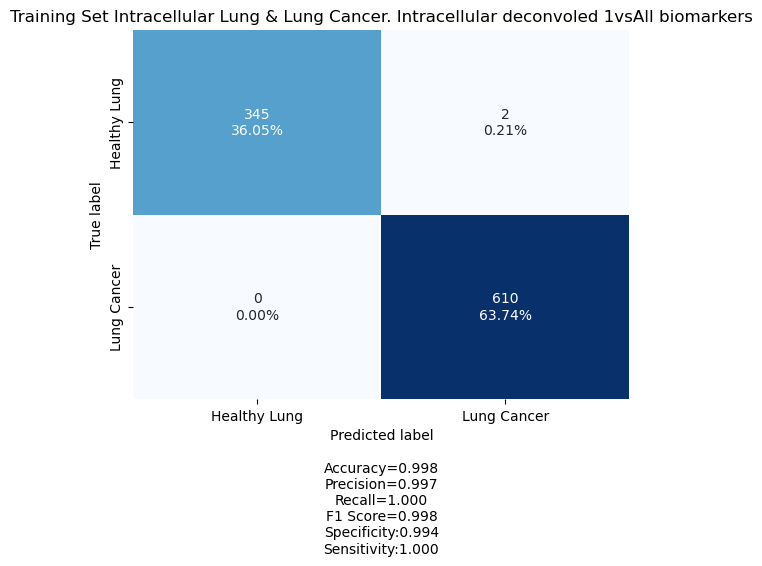

In [21]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#categories = ['Zero', 'One']
categories = [ 'Healthy Lung', 'Lung Cancer',]
title = "Training Set Intracellular Lung & Lung Cancer. Intracellular deconvoled 1vsAll biomarkers"
fig,panel = make_confusion_matrix(confusionMatrixData, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [22]:
imgFilePath = imgOut + "/trainingConfusionMatrix.png"
print(imgFilePath)
fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)

/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/img/trainingConfusionMatrix.png


/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/img/trainingConfusionMatrix.png
saving:
/private/groups/kimlab/aedavids/elife/testIntraCellularLungCancerBiomarkers.out/img/trainingROC.png


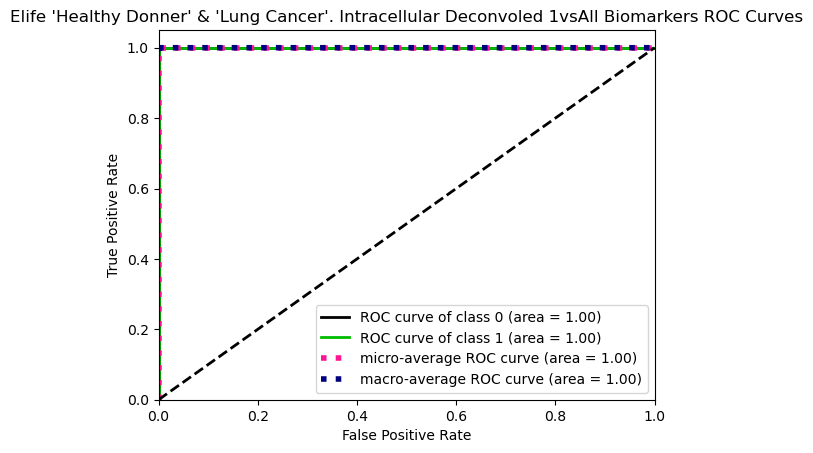

In [23]:
def plotROC():
    # https://scikit-plot.readthedocs.io/en/stable/metrics.html#scikitplot.metrics.plot_roc
    yProbability = lrModel.predict_proba(XScaled)
    rocPanel = skplt.metrics.plot_roc(y, yProbability,
                          title="Elife 'Healthy Donner' & 'Lung Cancer'. Intracellular Deconvoled 1vsAll Biomarkers ROC Curves"
                          )
    imgRocFilePath = imgOut + "/trainingROC.png"
    print(imgFilePath)
    fig =rocPanel.get_figure()
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saving:\n{imgRocFilePath}')

plotROC()

## Evaluate Validation Hold Out Data Set and Plot

In [24]:
# load
valGroupByGeneCountFilePath = sampleDataRoot + "/GTEx_TCGA_ValidateGroupby.csv"    
valGroupByGeneCountFilePath = load(valGroupByGeneCountFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
valGroupedByGeneDF = pd.read_csv(valGroupByGeneCountFilePath, sep=",", index_col="geneId")

# load meta data
valColDataFilePath = sampleDataRoot + "/GTEx_TCGA_ValidateColData.csv"
valColDataFilePath = load(valColDataFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
valColDataDF = pd.read_csv(valColDataFilePath, sep=",")
print(f'valColDataDF.shape : {valColDataDF.shape}')
colDataDF.iloc[0:3, :]

aedwip we do not have deseq scalling factors for hold out sets. we ran our 1vsAll docker in terra on
the training data set only

aedwip estimatedScalingFactorsFilePath = oneVsAllDataDir + "/estimatedSizeFactors.csv"
scalingFactorsPath = load(estimatedScalingFactorsFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
scalingFactorDF = pd.read_csv(scalingFactorsPath, sep=",")

SyntaxError: invalid decimal literal (1395577489.py, line 13)

In [ ]:
see cells  9, 10, 13. 14. 15 scale only do not fit anything, 17, 18, 19